In [11]:
import pandas as pd
from ALLCools.mcds import MCDS
from scipy.stats import f_oneway, ttest_ind, kruskal
import joblib
import anndata
from wmb import mm10
import pingouin as pg
import xarray as xr
import joblib
import numpy as np
import glob
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi']=300
plt.rcParams['pdf.fonttype']=42

In [12]:
gene_name_to_id = joblib.load('240112_DMG_CEF/gene_name_to_id_dict')
gene_id_to_name = joblib.load('240112_DMG_CEF/gene_id_to_name_dict')

In [13]:
_gender = 'Male'
mc_type = 'CHN'
p_cutoff = 1e-3

In [14]:
total_data = xr.open_dataset(f'{mc_type}.{_gender}.AgingMajorType.Region.Anova.Result.zarr')

/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/xarray/backends/plugins.py:114: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/xarray/backends/plugins.py:114: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [15]:
from amb import *
region_palette = get_major_region_palette()

In [16]:
all_cts = ['Oligo_NN',
           'DG_Glut',
           'CA1-ProS_Glut',
           'CA3_Glut',
           'Pvalb_Gaba',
            'Sst_Gaba',  
          'STR_D2_Gaba',
          'STR_D1_Gaba',
          'STR-PAL_Chst9_Gaba',
           'L23_IT_PPP_Glut',
           'L6bCT_ENT_Glut',
           'LA-BLA-BMA-PA_Glut',
           'CEA-BST_Gaba']

In [17]:
use_region_cts = ['.'.join(fp.split('/')[-1].split('.')[:2]) for fp in 
                  glob.glob('/ceph/gale-1/qzeng/AmbData/AgingMajorType.Region.Age/*')]
use_region_cts = list(set(use_region_cts))

In [18]:
use_region_cts

['LA-BLA-BMA-PA_Glut.Entorhinal_Cortex',
 'CEA-BST_Gaba.Nucleus_accumbens',
 'STR_D1_Gaba.Caudate_Putamen',
 'STR_D1_Gaba.Amygdala',
 'Sst_Gaba.Entorhinal_Cortex',
 'CA3_Glut.Anterior_Hippocampus',
 'STR_D2_Gaba.Nucleus_accumbens',
 'STR-PAL_Chst9_Gaba.Nucleus_accumbens',
 'Sst_Gaba.Posterior_Hippocampus',
 'Oligo_NN.Anterior_Hippocampus',
 'Pvalb_Gaba.Entorhinal_Cortex',
 'CA1-ProS_Glut.Anterior_Hippocampus',
 'STR-PAL_Chst9_Gaba.Amygdala',
 'Oligo_NN.Caudate_Putamen',
 'Oligo_NN.Amygdala',
 'CA3_Glut.Posterior_Hippocampus',
 'Oligo_NN.Posterior_Hippocampus',
 'LA-BLA-BMA-PA_Glut.Amygdala',
 'CA1-ProS_Glut.Posterior_Hippocampus',
 'Oligo_NN.PAG-PCG',
 'STR_D1_Gaba.Nucleus_accumbens',
 'L23_IT_PPP_Glut.Posterior_Hippocampus',
 'L6bCT_ENT_Glut.Posterior_Hippocampus',
 'L6bCT_ENT_Glut.Entorhinal_Cortex',
 'STR_D2_Gaba.Caudate_Putamen',
 'L23_IT_PPP_Glut.Entorhinal_Cortex',
 'STR_D2_Gaba.Amygdala',
 'Pvalb_Gaba.Frontal_Cortex',
 'DG_Glut.Anterior_Hippocampus',
 'DG_Glut.Posterior_Hippocam

In [30]:
dmg_num_df = {}

for region_ct in use_region_cts:
    ct, region = region_ct.split('.')
    tmpdf = total_data.sel(region_ct= region_ct)['anova_results'].to_pandas()
    up_tmpdf = tmpdf[(tmpdf['8wk'] <= tmpdf['9mo']) & (tmpdf['9mo'] <= tmpdf['18mo'])]
    down_tmpdf = tmpdf[(tmpdf['8wk'] >= tmpdf['9mo']) & (tmpdf['9mo'] >= tmpdf['18mo'])]
    tmpdf= pd.concat([up_tmpdf, down_tmpdf])
    tmpdf = tmpdf[tmpdf['corrected_pvalue'] < p_cutoff]
    tmpdf['change'] = abs(tmpdf['18mo'] - tmpdf['8wk'])
    tmpdf = tmpdf[tmpdf['change'] > 1e-3]
    #tmpdf = tmpdf[tmpdf['pvalue'] < p_cutoff]
    dmg_num_df[region_ct] = [ct, region, tmpdf.shape[0]]

dmg_num_df = pd.DataFrame(dmg_num_df).T
dmg_num_df.columns = ['CellType','Region','DMG_Number']
dmg_num_df.head()

,CellType,Region,DMG_Number
LA-BLA-BMA-PA_Glut.Entorhinal_Cortex,LA-BLA-BMA-PA_Glut,Entorhinal_Cortex,14
CEA-BST_Gaba.Nucleus_accumbens,CEA-BST_Gaba,Nucleus_accumbens,2027
STR_D1_Gaba.Caudate_Putamen,STR_D1_Gaba,Caudate_Putamen,15288
STR_D1_Gaba.Amygdala,STR_D1_Gaba,Amygdala,10
Sst_Gaba.Entorhinal_Cortex,Sst_Gaba,Entorhinal_Cortex,0


/home/qz/miniconda3/envs/allcools/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


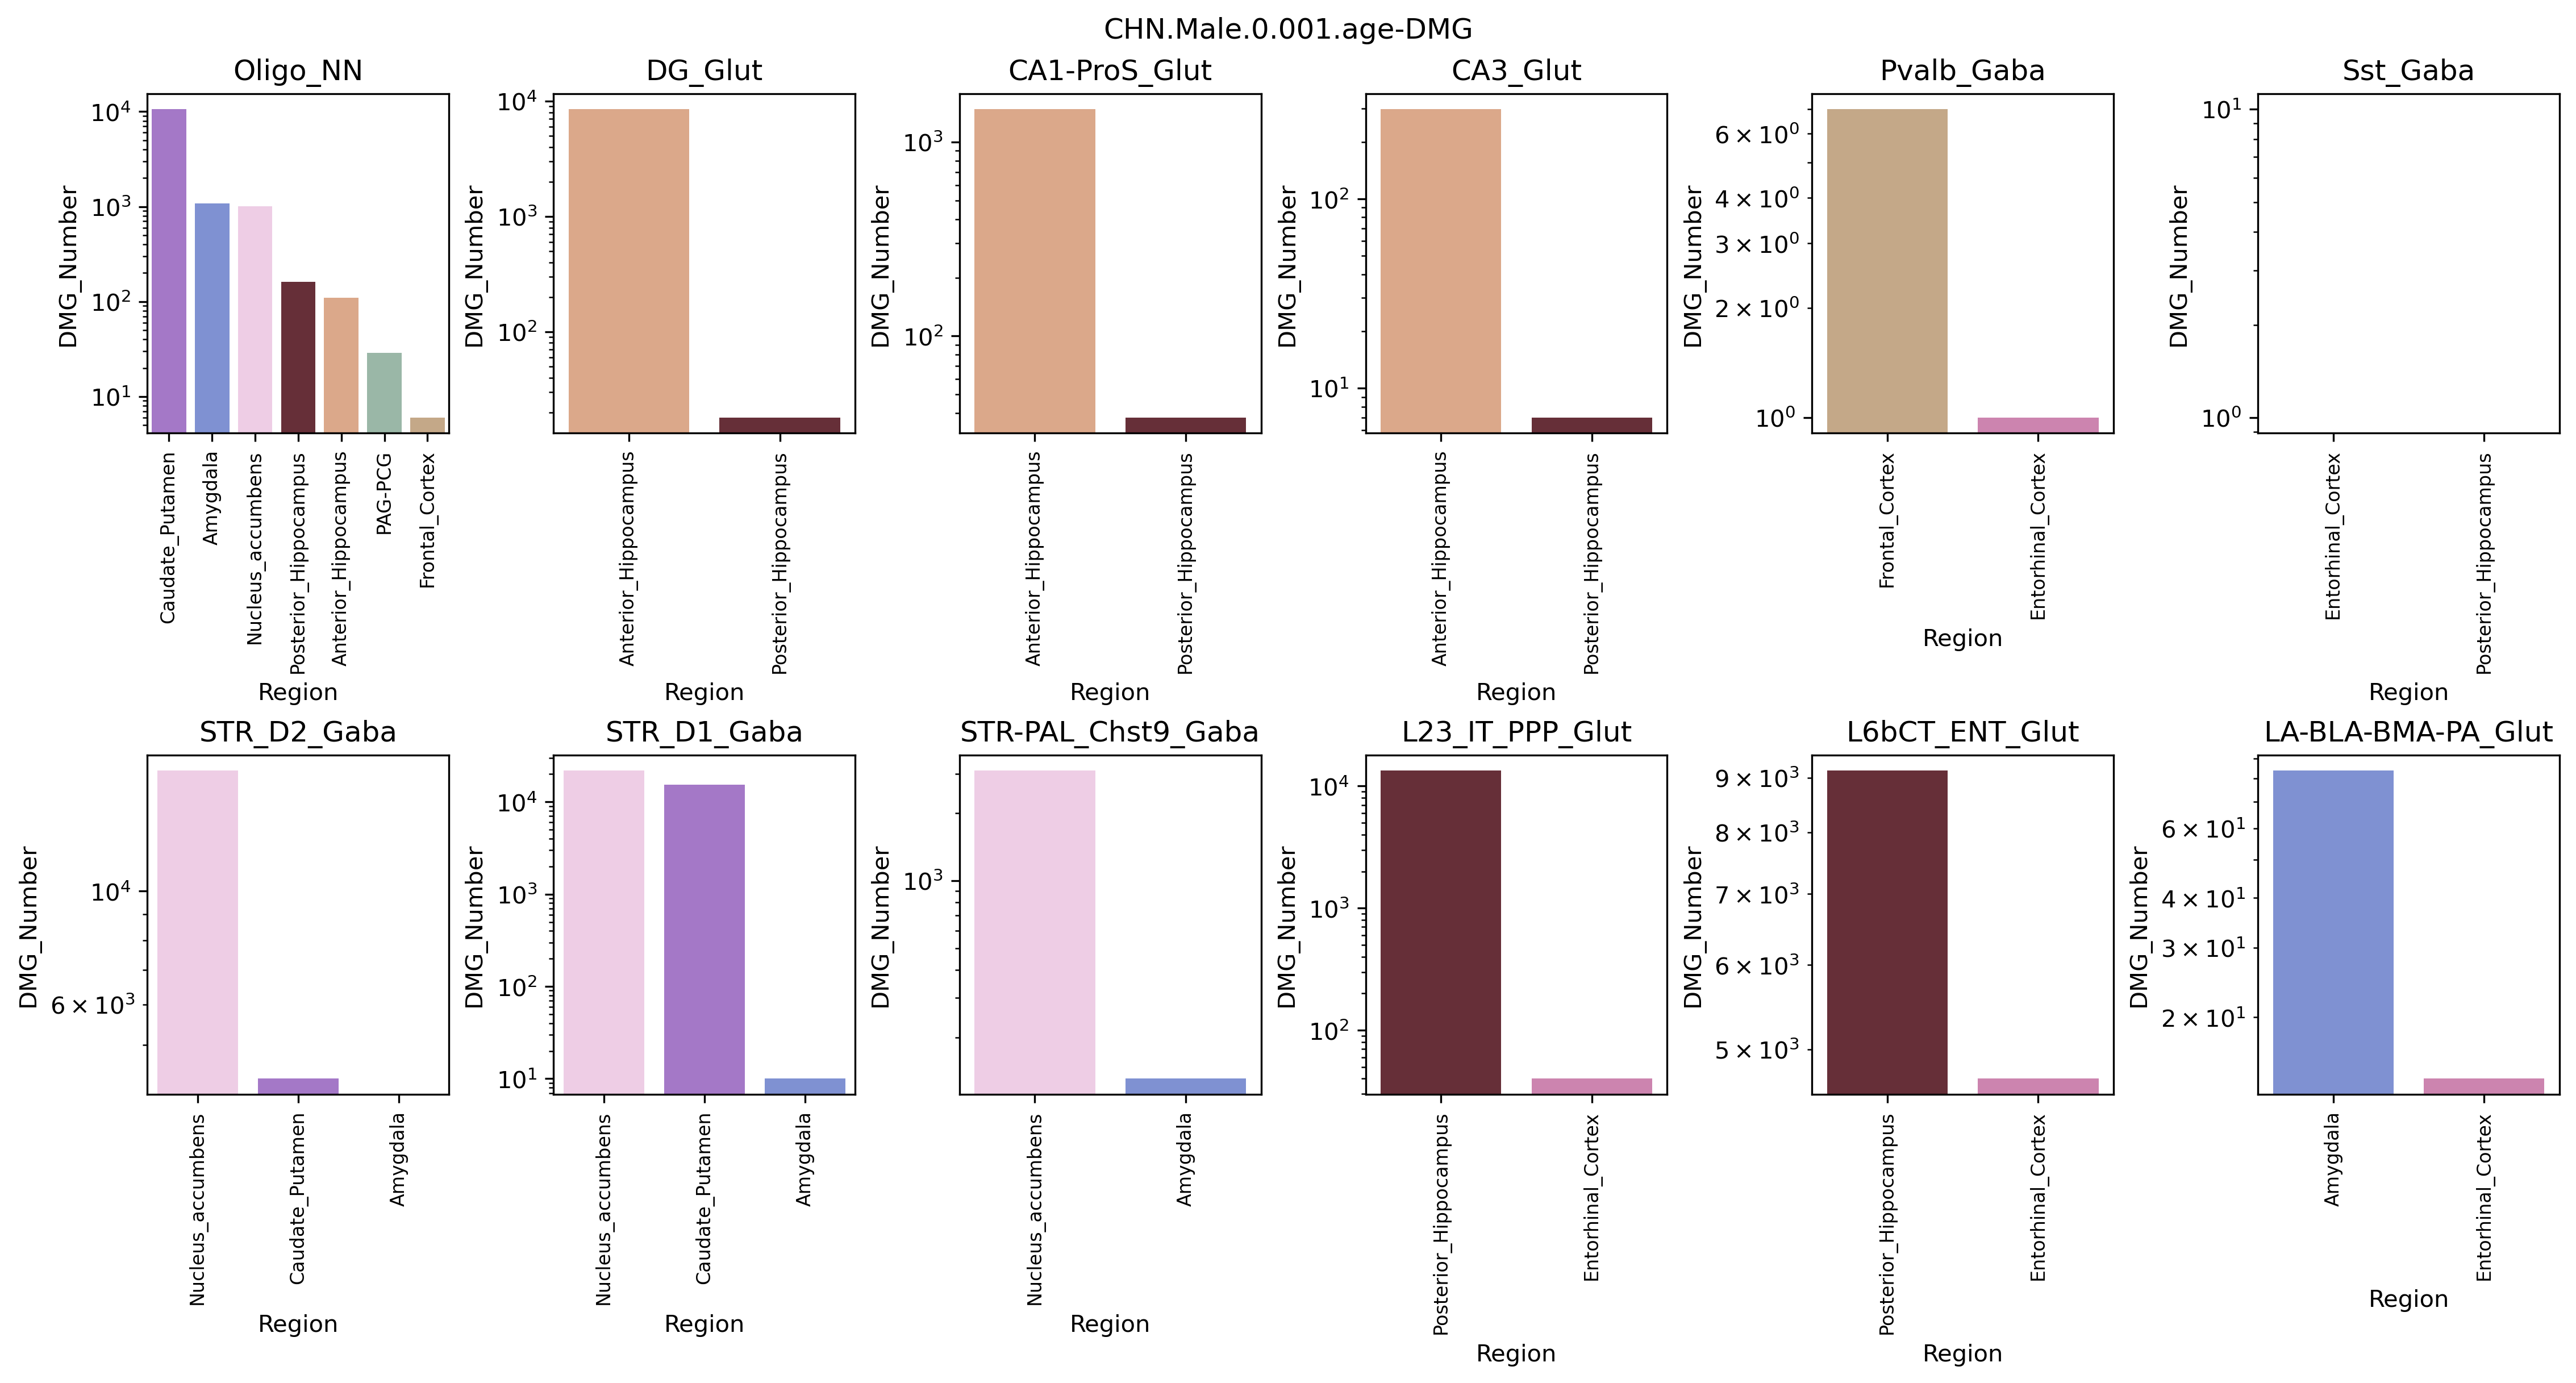

In [33]:
fig, axes = plt.subplots(figsize = (15,8),nrows = 2, 
                         ncols =6, dpi = 300, constrained_layout = True)

for ct, ax in zip(all_cts[:12], axes.ravel()):
    to_plot = dmg_num_df[dmg_num_df['CellType'] == ct]
    to_plot = to_plot.sort_values('DMG_Number', ascending = False)
    # bar1 = sns.barplot(data = to_plot, ax= ax, x="Region",  y="All aDMRs",  color='darkblue',dodge=False)
    # bar1 = sns.barplot(data = to_plot,ax= ax,  x="Region",  y="Aging Hyper", color='red', dodge=False)
    
    sns.barplot(data = to_plot,
                x='Region', 
                y="DMG_Number", 
                ax = ax,
                hue = 'Region',
                palette = region_palette,
                dodge=False
                )
    ax.get_legend().remove()
    ax.set_title(ct)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    ax.set_yscale('log')
plt.suptitle(f"{mc_type}.{_gender}.{p_cutoff}.age-DMG")
fig.savefig(f"figure/logy_{mc_type}.{_gender}.{p_cutoff}.regional_dmg_number.pdf", bbox_inches = 'tight')    